# Training ensemble models on balanced dataset

## Model characteristics

- **Data**: balanced dataset with 1.7m entries, containing data for muons(label = 0) and pions (label=1)

- **Classifiers**: Lightgbm, xgboost, Adaboost

- **Classifier type**: binary 

- Features (3 Nos.):

    - track_momentum
    
    - ring_radius
    
    - total_hits_filtered
    

- **Preprocessing**: 

    - filtering noise in hit times
    
    - feature scaling: not required for tree based methods
    

## Data preparation

- Original Source: "/data/bvelghe/capstone2022/C/2018E.EOSlist.CTRL_patched.h5"
- Balanced data set binned on 3 momentum bins:
    - 15-25 GeV/C
    - 25-35 GeV/C
    - 35-45 GeV/C

In [376]:
# Imports

import os
import sys
import glob

from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    plot_roc_curve,    
    auc, 
    accuracy_score,
    confusion_matrix, 
    classification_report,
    precision_recall_curve
    
)
import optuna

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import h5py 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

__file__ = "../utils/helpers.py"
SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(os.path.dirname(SCRIPT_DIR))
from utils.helpers import compute_seq_id, get_config, get_logger
from dataset.rich_dataset import *

In [219]:
!nvidia-smi

Wed Jun  8 08:24:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 30%   33C    P8     5W / 250W |   8690MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 30%   

In [73]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Fri_Dec_17_18:16:03_PST_2021
Cuda compilation tools, release 11.6, V11.6.55
Build cuda_11.6.r11.6/compiler.30794723_0


## 1. Extracting data from Original dataset (C : ~ 9 m entries)

In [4]:
# 1. Extracting the whole data Frame from original patched file (C)

# dset_path = "../Run008594.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01_patched.h5"
dset_path = "/data/bvelghe/capstone2022/C/2018E.EOSlist.CTRL_patched.h5"
dset_unbalanced = RICHDataset(
    dset_path
)

2022-06-06 12:47:41,174  INFO      data_version: 5f0df761-9a34-4554-9c50-dc0b338dc19a
2022-06-06 12:47:41,177  INFO      description: NA62 RICH PID dataset - MDS Capstone project - Thu 26 May 2022 09:33:42 AM CEST <bob.velghe@triumf.ca>
2022-06-06 12:47:41,181  INFO      entries: 9662769
2022-06-06 12:47:41,182  INFO      muon_offset: 0
2022-06-06 12:47:41,183  INFO      pion_offset: 8583495
2022-06-06 12:47:41,184  INFO      positron_offset: 9567650
2022-06-06 12:47:42,122  INFO      hit map size: 77302160 bytes
2022-06-06 12:47:42,128  INFO      Offsets: {'entries': 9662769, 'muon': 0, 'pion': 8583495, 'positron': 9567650}
2022-06-06 12:47:42,157  INFO      Entries: 9662769
2022-06-06 12:47:42,160  INFO      Muons start at index: 0
2022-06-06 12:47:42,162  INFO      Pions start at index: 8583495
2022-06-06 12:47:42,164  INFO      Positron start at index: 9567650
2022-06-06 12:47:43,538  INFO      Total indices: 9662767
2022-06-06 12:47:43,541  INFO      Total Train indices: 0
2022-06

In [77]:
# Function to convert data into pandas dataframe
def dataset_gbt(dset):
    "Returns dataset with momentum, ring radius, total hits, center positions"
    mu_off = dset.offsets['muon']
    pi_off = dset.offsets['pion']
    pos_off = dset.offsets['positron']
    entries = dset.offsets['entries']

    labels = np.zeros(entries, dtype=np.int32)
    labels[mu_off:pi_off] = 0                           # Muon
    labels[pi_off:pos_off] = 1                          # Pion
    labels[pos_off:] = 2                              # Positron

    total_hits = dset.hit_mapping[1:] - dset.hit_mapping[:-1]

    ring_centre_pos_x = dset.event_array['ring_centre_pos'][:, 0]
    ring_centre_pos_y = dset.event_array['ring_centre_pos'][:, 1]

    df = pd.DataFrame(
        {
            'track_momentum' : dset.event_array['track_momentum'], 
            'ring_radius': dset.event_array['ring_radius'],
            'total_hits': total_hits,
            'ring_centre_pos_x': ring_centre_pos_x,
            'ring_centre_pos_y': ring_centre_pos_y,
            'labels': labels
        },
    )
    return df

In [78]:
df_unbalanced = dataset_gbt(dset_unbalanced)
df_unbalanced.shape

(9662769, 6)

In [354]:
df_unbalanced

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels
0,26.948496,179.391769,22,-4.097735,31.231167,0
1,28.132404,178.753250,43,-156.361954,-131.826675,0
2,31.447334,180.091827,91,-49.356911,-90.976852,0
3,17.581686,160.696716,15,-54.584312,-29.460228,0
4,51.211544,189.128403,28,-114.221886,57.083755,0
...,...,...,...,...,...,...
9662764,31.850220,192.431152,32,-113.566689,-57.402962,2
9662765,12.499146,190.746674,56,-321.155853,-3.086937,2
9662766,29.423574,192.198502,22,-85.888626,69.484283,2
9662767,36.714138,191.890732,90,-122.784370,83.730347,2


In [79]:
# Value counts of the classes (0: muon, 1: pion, 2: positron)
df_unbalanced.labels.value_counts()

0    8583495
1     984155
2      95119
Name: labels, dtype: int64

## 2. Creating balanced dataset C (1.7 m entries) and adding total hits

In [81]:
# Converting combined balanced dataset C to pandas dataframe
df_temp = pd.read_hdf('/fast_scratch_1/capstone_2022/datasetC_combined.h5')
df_temp.shape

(1731226, 15)

In [355]:
# Combined balanced dataset of "/data/bvelghe/capstone2022/C/2018E.EOSlist.CTRL_patched.h5"
df_temp

,run_id,burst_id,event_id,track_id,track_momentum,chod_time,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,label,original_index,momentum-bin
original_index,,,,,,,,,,,,,,,
2687658,9011,887,1800376,0,24.691673,16.837833,177.461960,-60.107861,106.794441,5.328789e-10,1.000000,9.393904e-21,0,2687658,15-25
4676657,8992,1059,770241,0,23.396029,9.284823,175.237564,-12.228768,11.319837,1.080940e-22,1.000000,6.127901e-07,0,4676657,15-25
3262259,9007,477,1922012,0,15.891424,22.654669,152.091827,-241.150375,-172.708389,1.216099e-37,1.000000,1.216099e-37,0,3262259,15-25
5473943,8987,1295,1634792,0,16.026428,23.254803,155.005783,-65.635712,-0.601753,1.216099e-37,1.000000,1.216099e-37,0,5473943,15-25
8071459,8971,654,2010374,0,21.888950,24.337191,172.810287,-231.750687,159.534821,4.307081e-14,1.000000,7.490480e-21,0,8071459,15-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9567636,8968,7,563388,0,35.011139,16.212551,177.854492,-213.486633,-2.936464,1.000000e+00,0.000043,2.887881e-20,1,9567636,35-45
9567637,8968,7,572378,0,38.958267,19.714800,182.430420,-98.754082,92.138535,1.000000e+00,0.146916,3.528800e-07,1,9567637,35-45
9567638,8968,7,583135,0,38.474777,13.620609,176.691132,-145.546219,-77.260124,1.000000e+00,0.001099,5.301323e-11,1,9567638,35-45


In [83]:
# Adding total hits from original dataset C by mapping original indices
df_balanced = df_unbalanced.iloc[df_temp.original_index,:]
df_balanced

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels
2687658,24.691673,177.461960,22,-60.107861,106.794441,0
4676657,23.396029,175.237564,21,-12.228768,11.319837,0
3262259,15.891424,152.091827,19,-241.150375,-172.708389,0
5473943,16.026428,155.005783,35,-65.635712,-0.601753,0
8071459,21.888950,172.810287,48,-231.750687,159.534821,0
...,...,...,...,...,...,...
9567636,35.011139,177.854492,28,-213.486633,-2.936464,1
9567637,38.958267,182.430420,21,-98.754082,92.138535,1
9567638,38.474777,176.691132,31,-145.546219,-77.260124,1
9567646,36.989967,180.464676,51,-186.481369,-47.899498,1


## 3. Filtering hits data and adding total_hits_filtered

In [84]:
# Filtering noise for total hits

def filter_hits(
    dset_unbalanced=dset_unbalanced, 
    df_balanced= df_balanced, 
    delta = 0.3
):
    """Filter hits based on chod time hit time delta"""
    
    # Event indices in balanced dataset
    event_nums = df_balanced.index

    # Defining total_hits_filtered
    total_hits_filtered = pd.Series(np.zeros(df_balanced.shape[0], dtype='int32'), index=event_nums,dtype='int32')

    for event_idx in event_nums:
        # Finding the number of hits for each event in the hit_array from hit_mapping
        idx_from = dset_unbalanced.hit_mapping[event_idx]
        idx_to = dset_unbalanced.hit_mapping[event_idx+1]
        hit_times = dset_unbalanced.hit_array['hit_time'][idx_from:idx_to]

        # Extracting delta for each event
        delta_time = dset_unbalanced.event_array[event_idx]["chod_time"] - hit_times

        # Fetching the count of hit_times in the range hit_time +- delta_tolerance
        total_hits_filtered[event_idx] = delta_time[np.abs(delta_time) < delta].shape[0]

    # updating df_balanced for total hits
    df_balanced_copy = df_balanced
    df_balanced_copy['total_hits_filtered'] = total_hits_filtered
    return df_balanced_copy
    

In [85]:
df_balanced_filtered = filter_hits()

/tmp/ipykernel_12921/3182433742.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_balanced_copy['total_hits_filtered'] = total_hits_filtered


In [87]:
# balanced data filtered for hits by delta value = 0.3
df_balanced_filtered

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels,total_hits_filtered
2687658,24.691673,177.461960,22,-60.107861,106.794441,0,19
4676657,23.396029,175.237564,21,-12.228768,11.319837,0,9
3262259,15.891424,152.091827,19,-241.150375,-172.708389,0,10
5473943,16.026428,155.005783,35,-65.635712,-0.601753,0,9
8071459,21.888950,172.810287,48,-231.750687,159.534821,0,12
...,...,...,...,...,...,...,...
9567636,35.011139,177.854492,28,-213.486633,-2.936464,1,19
9567637,38.958267,182.430420,21,-98.754082,92.138535,1,17
9567638,38.474777,176.691132,31,-145.546219,-77.260124,1,12
9567646,36.989967,180.464676,51,-186.481369,-47.899498,1,32


## 4. Removing anomalous observations

### Some EDA on ring_centre_pos, ring_radius, total_hits_filtered

In [130]:
df_balanced_filtered.describe().loc[['min', 'max'],:]

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels,total_hits_filtered
min,15.000096,0.000000e+00,5.0,-9.389281e+08,-683145280.0,0.0,0.0
max,44.999985,1.366392e+09,332.0,1.183359e+09,307175360.0,1.0,107.0


In [119]:
df_balanced_filtered.query("(ring_centre_pos_x < -1000)")

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels,total_hits_filtered
8059195,23.793406,1.762612e+08,13,-1.526504e+08,8.812386e+07,0,9
5064455,24.805933,1.153027e+06,7,-9.988351e+05,-5.764483e+05,0,6
8898119,23.059324,2.053354e+05,7,-1.777249e+05,-1.025705e+05,1,5
128444,34.297417,1.084154e+09,32,-9.389281e+08,-5.420366e+08,0,6
8777544,41.619984,1.872246e+05,51,-9.369404e+04,-1.623283e+05,1,16
9537126,38.256817,7.900591e+05,8,-6.843749e+05,3.951522e+05,1,2


In [126]:
df_balanced_filtered.query("(ring_centre_pos_x > 1000)")

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels,total_hits_filtered
6222440,21.997339,167.758591,47,999999.0,999999.0,0,8
7680853,23.585865,170.338104,42,999999.0,999999.0,0,8
1890516,18.394594,163.609039,26,999999.0,999999.0,0,10
540180,18.030018,163.829178,12,999999.0,999999.0,0,4
3180785,24.080837,181.336777,11,999999.0,999999.0,0,9
...,...,...,...,...,...,...,...
9563350,35.584480,176.219864,17,999999.0,999999.0,1,16
9564760,37.279251,999999.000000,37,999999.0,999999.0,1,28
9564891,38.167229,999999.000000,30,999999.0,999999.0,1,10
9564895,39.773903,999999.000000,58,999999.0,999999.0,1,21


In [129]:
df_balanced_filtered.query("(ring_centre_pos_y < -1000)")

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels,total_hits_filtered
294334,17.109905,1.366392e+09,42,1.183359e+09,-6.831453e+08,0,13
5064455,24.805933,1.153027e+06,7,-9.988351e+05,-5.764483e+05,0,6
8624808,23.743502,2.244237e+05,26,1.943415e+05,-1.121700e+05,1,6
8736939,24.212620,2.653839e+05,13,2.294969e+05,-1.324824e+05,1,4
8898119,23.059324,2.053354e+05,7,-1.777249e+05,-1.025705e+05,1,5
128444,34.297417,1.084154e+09,32,-9.389281e+08,-5.420366e+08,0,6
7302189,26.279650,1.620966e+05,40,1.401269e+05,-8.082596e+04,0,6
8741767,34.186363,1.694805e+05,6,1.468483e+05,-8.473616e+04,1,5
9094336,30.220053,9.294251e+05,279,8.047375e+05,-4.645929e+05,1,10
8593158,39.919903,4.948897e+05,8,4.284111e+05,-2.473435e+05,1,1


In [155]:
df_balanced_filtered.query("(ring_radius< 1)")

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels,total_hits_filtered
1270035,22.536070,0.0,51,999999.0,999999.0,0,11
7930228,21.853220,0.0,43,999999.0,999999.0,0,4
7726302,19.446329,0.0,67,999999.0,999999.0,0,8
1542273,17.271717,0.0,16,999999.0,999999.0,0,13
6517352,21.950239,0.0,39,999999.0,999999.0,0,11
...,...,...,...,...,...,...,...
9359605,41.205345,0.0,26,999999.0,999999.0,1,19
9393928,42.198200,0.0,33,999999.0,999999.0,1,21
9398950,43.813347,0.0,21,999999.0,999999.0,1,7
9523443,36.379070,0.0,64,999999.0,999999.0,1,14


In [141]:
df_balanced_filtered.query("ring_radius>1000")

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels,total_hits_filtered
2073415,21.390589,999999.0,43,999999.0,999999.0,0,11
2872308,18.367033,999999.0,76,999999.0,999999.0,0,14
5870625,22.545231,999999.0,34,999999.0,999999.0,0,15
5947267,21.746426,999999.0,47,999999.0,999999.0,0,12
5539856,24.952852,999999.0,60,999999.0,999999.0,0,13
...,...,...,...,...,...,...,...
9560994,36.499996,999999.0,30,999999.0,999999.0,1,18
9561555,44.575218,999999.0,51,999999.0,999999.0,1,25
9564760,37.279251,999999.0,37,999999.0,999999.0,1,28
9564891,38.167229,999999.0,30,999999.0,999999.0,1,10


In [163]:
df_balanced_filtered.query("total_hits_filtered>500")

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels,total_hits_filtered


In [171]:
# Cleaning data for anomalous data
def clean_data(df=df_balanced_filtered):
    """Clean data for anomalous inputs"""
    
    # ring_center_pos_X 
    df_clean = df[
        (df['ring_centre_pos_x']<1000) & 
        (df['ring_centre_pos_x']>-1000)
    ]
    
    # ring_center_pos_Y 
    df_clean = df_clean[
        (df_clean['ring_centre_pos_y']<1000) &
        (df_clean['ring_centre_pos_y']>-1000)
    ]
    
    # Ring radius 
    df_clean = df_clean[
        (df_clean["ring_radius"]>1) & 
        (df_clean["ring_radius"]<1000)
    ]
    print(f"Total entries removed: {df.shape[0] - df_clean.shape[0]}")
    return df_clean

In [172]:
%%time
# data post filtering anomalous entries
df_clean = clean_data()

Total entries removed: 14285
CPU times: user 184 ms, sys: 36 ms, total: 220 ms
Wall time: 924 ms


In [173]:
df_clean

,track_momentum,ring_radius,total_hits,ring_centre_pos_x,ring_centre_pos_y,labels,total_hits_filtered
2687658,24.691673,177.461960,22,-60.107861,106.794441,0,19
4676657,23.396029,175.237564,21,-12.228768,11.319837,0,9
3262259,15.891424,152.091827,19,-241.150375,-172.708389,0,10
5473943,16.026428,155.005783,35,-65.635712,-0.601753,0,9
8071459,21.888950,172.810287,48,-231.750687,159.534821,0,12
...,...,...,...,...,...,...,...
9567636,35.011139,177.854492,28,-213.486633,-2.936464,1,19
9567637,38.958267,182.430420,21,-98.754082,92.138535,1,17
9567638,38.474777,176.691132,31,-145.546219,-77.260124,1,12
9567646,36.989967,180.464676,51,-186.481369,-47.899498,1,32


In [174]:
df_clean.labels.value_counts()

0    860863
1    856078
Name: labels, dtype: int64

## 5. Features, train test split

In [175]:
# Selecting X & y
X = df_clean.loc[:, [
    'track_momentum',
    'ring_radius',
    'total_hits_filtered'
]]

y = df_clean.loc[:,'labels']

In [176]:
%%time

# Training and validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y, 
    test_size=0.25
)

CPU times: user 887 ms, sys: 44.3 ms, total: 931 ms
Wall time: 1.94 s


In [177]:
# Testing for stratification  - training set
y_train.value_counts()

0    645647
1    642058
Name: labels, dtype: int64

In [178]:
# Testing for stratification - validation set
y_test.value_counts()

0    215216
1    214020
Name: labels, dtype: int64

In [224]:
def model_results(model, y_test=y_test, y_pred=y_pred):
    print('\nClassification Report\n')
    print(classification_report(
            y_test, y_pred, 
            target_names=['Muons', 'Pions']
        )
    )
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm,
                         index = ['Muons', 'Pions'], 
                         columns = ['Muons', 'Pions'])
    plt.figure(figsize=(5,5))
    sns.heatmap(cm_df, annot=True, cmap='YlGnBu')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

## 6. Results of Training Gradient Boosted Models (LGBM, XGB, AdaB)

### 6.1 Baseline lightGBM classifier results

In [331]:
%%time
lgbm_c = lgb.LGBMClassifier(random_state=123)
lgbm_c.fit(X_train, y_train)

CPU times: user 4min 18s, sys: 6.59 s, total: 4min 25s
Wall time: 5.11 s


LGBMClassifier(random_state=123)

In [332]:
y_pred_lgb = lgbm_c.predict(X_test)


Classification Report

              precision    recall  f1-score   support

       Muons       0.94      0.93      0.94    215216
       Pions       0.93      0.94      0.94    214020

    accuracy                           0.94    429236
   macro avg       0.94      0.94      0.94    429236
weighted avg       0.94      0.94      0.94    429236



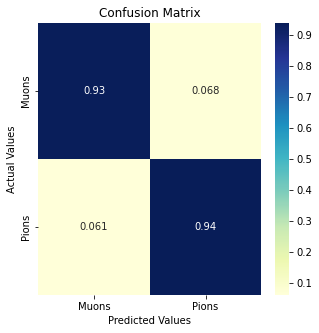

In [333]:
model_results(lgbm_c, y_pred = y_pred_lgb)

## 6.2 Baseline XGBoost Classifier

In [334]:
%%time
xgb_cl = XGBClassifier(
    random_state=123,
    tree_method="gpu_hist",
    gpu_id=7,
    predictor="gpu_predictor",
)
xgb_cl.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 13.2 s, sys: 586 ms, total: 13.8 s
Wall time: 903 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=7, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=64,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [336]:
y_pred_xgb = xgb_cl.predict(X_test)


Classification Report

              precision    recall  f1-score   support

       Muons       0.94      0.93      0.93    215216
       Pions       0.93      0.94      0.93    214020

    accuracy                           0.93    429236
   macro avg       0.93      0.93      0.93    429236
weighted avg       0.93      0.93      0.93    429236



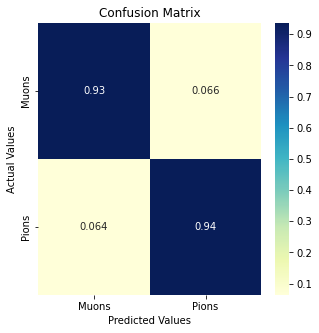

In [337]:
model_results(xgb_cl, y_pred = y_pred_xgb)

## 6.3 Adaboost baseline model

In [340]:
%%time
ab_cl = AdaBoostClassifier(
    random_state=123,
    n_estimators=100
)
ab_cl.fit(X_train, y_train)

CPU times: user 1min 26s, sys: 216 ms, total: 1min 27s
Wall time: 1min 27s


AdaBoostClassifier(n_estimators=100, random_state=123)

In [341]:
y_pred_adb = ab_cl.predict(X_test)


Classification Report

              precision    recall  f1-score   support

       Muons       0.91      0.93      0.92    215216
       Pions       0.93      0.91      0.92    214020

    accuracy                           0.92    429236
   macro avg       0.92      0.92      0.92    429236
weighted avg       0.92      0.92      0.92    429236



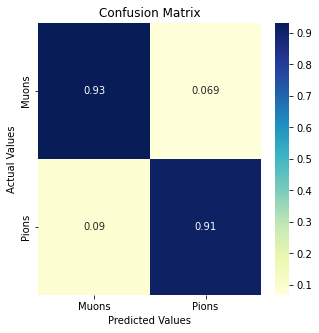

In [342]:
model_results(xgb_cl, y_pred=y_pred_adb)

In [343]:
results_gbm = pd.DataFrame({
    "track_momentum": X_test.track_momentum,
    "ring_radius": X_test.ring_radius,
    "total_hits_filtered": X_test.total_hits_filtered,
    "y_test": y_test,
    "y_pred_lgb": y_pred_lgb,
    "y_pred_xgb": y_pred_xgb,
    "y_pred_adb": y_pred_adb,
    "compare_xgb_lgb": (y_pred_lgb == y_pred_xgb) 
    
})
results_gbm

,track_momentum,ring_radius,total_hits_filtered,y_test,y_pred_lgb,y_pred_xgb,y_pred_adb,compare_xgb_lgb
9160344,34.783936,173.657471,15,1,1,1,1,True
9006947,21.358488,157.571793,9,1,1,1,1,True
2296860,16.737009,156.325745,10,0,0,0,0,True
7309038,35.763229,181.071976,20,0,1,1,1,True
8773890,25.676950,164.774445,15,1,1,1,1,True
...,...,...,...,...,...,...,...,...
6426497,15.171918,148.132172,8,0,0,0,0,True
9031233,38.342449,178.207581,7,1,1,1,1,True
3583000,24.429150,184.198166,12,0,0,0,0,True
7387760,36.527206,184.056229,30,0,0,0,0,True


## 7. Analysis of mismatch in predictions by different GBMs

In [253]:
# comparison between lgbm and xgb for mismatch
results_gbm[results_gbm.compare_xgb_lgb==False]


,track_momentum,ring_radius,total_hits_filtered,y_test,y_pred_lgb,y_pred_xgb,y_pred_adb,compare_xgb_lgb
9095852,42.545795,183.858673,16,1,0,1,0,False
9413042,38.293095,182.300613,14,1,0,1,0,False
6200087,25.022940,169.802933,8,0,1,0,1,False
2194963,43.682941,184.485184,11,0,0,1,0,False
8708934,43.506897,184.148071,16,1,0,1,0,False
...,...,...,...,...,...,...,...,...
8967149,36.563793,181.626389,19,1,1,0,0,False
3452862,43.941921,184.054123,22,0,1,0,0,False
1260495,42.033985,183.656754,7,0,1,0,0,False
9399697,43.763897,184.052185,22,1,1,0,0,False


In [345]:
mis_preds = results_gbm.query('y_test != y_pred_xgb')
mis_preds

,track_momentum,ring_radius,total_hits_filtered,y_test,y_pred_lgb,y_pred_xgb,y_pred_adb,compare_xgb_lgb
7309038,35.763229,181.071976,20,0,1,1,1,True
9524628,35.152458,182.022614,17,1,0,0,0,True
3765202,38.716934,181.350815,17,0,1,1,1,True
5767123,43.186146,183.903671,9,0,1,1,0,True
9388003,43.500027,184.183990,8,1,1,0,0,False
...,...,...,...,...,...,...,...,...
7076213,30.681997,177.461502,19,0,1,1,0,True
5495378,39.709282,182.708633,13,0,1,1,0,True
1246677,43.049343,182.280701,12,0,1,1,1,True
3988849,41.554111,181.001755,13,0,1,1,1,True


In [349]:
df_temp.index = df_temp.original_index
df_temp

,run_id,burst_id,event_id,track_id,track_momentum,chod_time,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,label,original_index,momentum-bin
original_index,,,,,,,,,,,,,,,
2687658,9011,887,1800376,0,24.691673,16.837833,177.461960,-60.107861,106.794441,5.328789e-10,1.000000,9.393904e-21,0,2687658,15-25
4676657,8992,1059,770241,0,23.396029,9.284823,175.237564,-12.228768,11.319837,1.080940e-22,1.000000,6.127901e-07,0,4676657,15-25
3262259,9007,477,1922012,0,15.891424,22.654669,152.091827,-241.150375,-172.708389,1.216099e-37,1.000000,1.216099e-37,0,3262259,15-25
5473943,8987,1295,1634792,0,16.026428,23.254803,155.005783,-65.635712,-0.601753,1.216099e-37,1.000000,1.216099e-37,0,5473943,15-25
8071459,8971,654,2010374,0,21.888950,24.337191,172.810287,-231.750687,159.534821,4.307081e-14,1.000000,7.490480e-21,0,8071459,15-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9567636,8968,7,563388,0,35.011139,16.212551,177.854492,-213.486633,-2.936464,1.000000e+00,0.000043,2.887881e-20,1,9567636,35-45
9567637,8968,7,572378,0,38.958267,19.714800,182.430420,-98.754082,92.138535,1.000000e+00,0.146916,3.528800e-07,1,9567637,35-45
9567638,8968,7,583135,0,38.474777,13.620609,176.691132,-145.546219,-77.260124,1.000000e+00,0.001099,5.301323e-11,1,9567638,35-45


### Comparative performance across momentum bins

#### A. Earlier considered momentum bins

<AxesSubplot:>

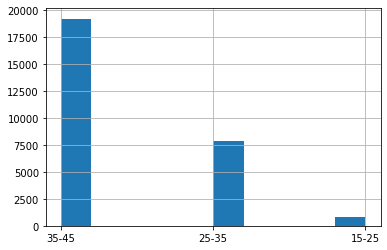

In [350]:
# Earlier considered momentum bins (15-25, 25-35, 35-45)
df_temp.loc[mis_preds.index, "momentum-bin"].hist()

#### B. Finer momentum bins

In [379]:
# Finer momentum bins
pd.options.plotting.backend = "plotly"
mis_preds.track_momentum.hist(bins=30)

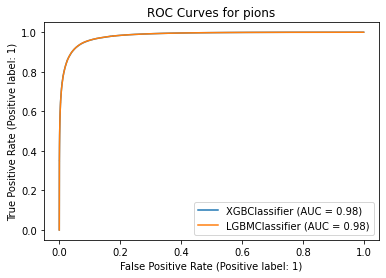

In [378]:
# ROC Curves
fig = None
fig = plot_roc_curve(xgb_cl, X_test, y_test)
fig = plot_roc_curve(lgbm_c, X_test, y_test, ax = fig.ax_)
plt.title("ROC Curves for pions")
plt.show()

## Hyperparameter tuning for xgboost

**Rationale for choosing xgboost**: Out of the three models, xgboost was chosen for hyperparameter optimization. 

- Although, xgboost usually is slow (~4 mins walltime for 1.7m entries) in comparison to LGBM (40s) but often outperforms LGBM as per reviews by users. 

- Further, its strong support for GPU and other parameters make it flexible for usage with parallel processing using APIs such as Rapids and Dask.

## Tuning using Optuna

In [ ]:
# Objective function

def objective(trial,data=X_train,target=y_train):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'tree_method':'gpu_hist', 
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBClassifier(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = accuracy_score(test_y, preds)
    
    return rmse

In [211]:
%%time
xgb_cl_tuned = xgb.XGBClassifier(
    
    random_state=123,
    tree_method="gpu_hist",
    gpu_id=7,
    predictor="gpu_predictor",
    n_estimators=5000,
    learning_rate=0.3,
    reg_lambda= 100,
    subsample=0.9,
    max_depth=2,
    
)
xgb_cl_tuned.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 11.5 s, sys: 2.01 s, total: 13.5 s
Wall time: 27 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=7, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=64,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=123,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=1, subsample=0.9,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [212]:
y_pred = xgb_cl_tuned.predict(X_test)

In [214]:
print('\nClassification Report\n')
print(classification_report(
    y_test, y_pred>0.5, 
    target_names=['Muons', 'Pions']
    )
)


Classification Report

              precision    recall  f1-score   support

       Muons       0.94      0.93      0.94    215216
       Pions       0.93      0.94      0.93    214020

    accuracy                           0.94    429236
   macro avg       0.94      0.94      0.94    429236
weighted avg       0.94      0.94      0.94    429236



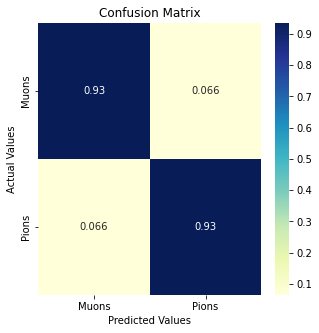

In [210]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Muons', 'Pions'], 
                     columns = ['Muons', 'Pions'])
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
%%time
# X and y
X = cudf.DataFrame(df_clean.loc[:, [
    'track_momentum',
    'ring_radius',
    'total_hits'
    ]]
)

y = cudf.Series(
    df_clean.loc[:,'labels']
)
# X = df_clean.loc[:, [
#     'track_momentum',
#     'ring_radius',
#     'total_hits'
#     ]]

# y = df_clean.loc[:,'labels']

# train test split using cuml train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(
    X, 
    y,
    stratify=y, 
    test_size=0.3,
    random_state=123,
    shuffle=True
)

dtrain = xgb.DMatrix(X_train, y_train)
dval   = xgb.DMatrix(X_validation, y_validation)

In [ ]:
# %%time
# train_test_split using sklearn train_test_split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     stratify=y, 
#     test_size=0.25,
#     random_state=123
# )

In [ ]:
y_train.value_counts()

In [ ]:
y_validation.value_counts()

In [ ]:
type(y_train)

In [ ]:
type(X_train)

In [ ]:
y_validation[y_validation==1]

In [ ]:
# %%time
# X_train_df = X_train.to_pandas()
# X_validation_df = X_validation.to_pandas()
# y_train_ps = y_train.to_pandas()
# y_validation_ps = y_validation.to_pandas()

In [ ]:
# imports
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.ensemble import AdaBoostClassifier

In [ ]:
params = {
    'tree_method' : 'gpu_hist',
    'max_depth' : 7,
    'max_leaves' : 15,
    'objective' : 'binary:logistic',
    'grow_policy' : 'lossguide',
    'predictor':'gpu_predictor',
    'eta' : 0.7,
    'eval_metric':'auc',
    'gpu_id': 3
}


evallist = [(dval, 'validation'), (dtrain, 'train')]
num_round=50

In [ ]:
%%time
# model using cudf/DMatrix (native xgboost)
xgb_native = xgb.train(params, dtrain, num_round, evallist)

predicts = xgb_native.predict(xgb.DMatrix(X_validation))
roc = ras(y_validation, predicts)
roc

In [ ]:
predicts.sum()

In [ ]:
# model instantiation (using pandas formats with sklearn API)
# xgb_cl = xgb.XGBClassifier(
# #     objective='binary:logistic',
# #     learning_rate=0.1,
# #     n_estimators=250,
# #     reg_lambda=1000,
#     seed=123,
# #     gpu_id=3,
# #     tree_method="gpu_hist",
# #     subsample=0.9,
# #     eval_metric='error',
# #     use_label_encoder=False,
# #     predictor="gpu_predictor",
# )

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [ ]:
%%time
xgb_cl.fit(
    X_train, 
    y_train, 
    eval_set=eval_set, 
    verbose=True, 
    early_stopping_rounds=20,
)

In [ ]:
y_pred = xgb_cl.predict(X_validation_df)

In [ ]:
(y_pred==1).sum()

In [ ]:
print('\nClassification Report\n')
print(classification_report(
    y_validation_ps, y_pred,
    )
)

In [ ]:
%%time
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_validation, label=y_validation)

In [ ]:
%%time
# model training settings
# evallist = [(dvalidation, 'validation'), (dtrain, 'train')]
evallist = [(dtrain, 'train')]
num_round = 250

In [ ]:
%%time
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=123)
clf_xgb.

In [ ]:
prediction = bst.predict(dvalidation)

In [ ]:
prediction[prediction>0.4]

In [ ]:
from sklearn.model_selection import train_test_split
X = df_clean.loc[:, [
    'track_momentum',
    'ring_radius',
    'total_hits'
    ]]

y = df_clean.loc[:,'labels']

# train test split
X_train, X_validation, y_train, y_validation = train_test_split(
    X, 
    y,
    stratify=y, 
    test_size=0.25,
    random_state = 123
)

In [ ]:
y.astype("category")

In [ ]:
xgb_cl = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed=123,
    gpu_id=3,
    tree_method="gpu_hist",
#     predictor=gpu_predictor,
    enable_categorical=True,
    use_label_encoder=False
)

In [ ]:
%%time
xgb_cl.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_metric='aucpr',
    eval_set=[(X_validation, y_validation)]
)

## Using pandas dataframe

In [ ]:
cupy.cuda.Device(3).use()

In [ ]:
from cuml import train_test_split

In [ ]:
%%time
# X and y
X = cudf.DataFrame(df_clean.loc[:, [
    'track_momentum',
    'ring_radius',
    'total_hits'
    ]]
)

y = cudf.Series(
    df_clean.loc[:,'labels']
)

# train test split
X_train, X_validation, y_train, y_validation = train_test_split(
    X, 
    y,
    stratify=y, 
    test_size=0.25,
    random_state = 123
)

In [ ]:
%%time
X_train = X_train.to_numpy()
X_validation = X_validation.to_numpy()
y_train = y_train
y_validation = y_train

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
%%time
# Training and validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y, 
    test_size=0.25
)

## Test Results
dataset: 8594 (patched)

In [ ]:
# Loading
dset_path_test = "../Run008594.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01_patched.h5"
dset_test = RICHDataset(
    dset_path
)